<a href="https://colab.research.google.com/github/NegativeGravity/Trading_Practice/blob/main/Learning/Simple_RNN_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [21]:
def get_btc_data():
    print("Fetching Data...")
    df = yf.download('BTC-USD', start='2022-01-01', end='2025-01-01', progress=False)
    data = df[['Close']].values.astype(float)

    # Split Train/Test (80% Train, 20% Test)
    train_size = int(len(data) * 0.8)
    train_raw, test_raw = data[:train_size], data[train_size:]

    return train_raw, test_raw

# Helper for Neural Networks to create sequences
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

In [22]:
def run_arima(train_data, test_data):
    print("\n--- Running ARIMA ---")
    history = [x[0] for x in train_data]
    test_values = [x[0] for x in test_data]
    predictions = []

    # Rolling Forecast
    print(f"Predicting {len(test_values)} steps (this may take a moment)...")
    for t in range(len(test_values)):
        model = ARIMA(history, order=(5,1,0))
        model_fit = model.fit()
        output = model_fit.forecast()
        yhat = output[0]
        predictions.append(yhat)
        history.append(test_values[t])

    return np.array(predictions)

In [23]:
class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleRNN, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    def forward(self, x):
        out, _ = self.rnn(x)
        return self.fc(out[:, -1, :])

def run_rnn(train_raw, test_raw, seq_length=60):
    print("\n--- Running RNN ---")

    scaler = MinMaxScaler(feature_range=(0, 1))
    train_scaled = scaler.fit_transform(train_raw)

    total_data = np.concatenate((train_raw, test_raw), axis=0)
    total_scaled = scaler.transform(total_data)

    X_train, y_train = create_sequences(train_scaled, seq_length)

    inputs = total_scaled[len(total_scaled) - len(test_raw) - seq_length:]
    X_test, _ = create_sequences(inputs, seq_length)

    # Tensors
    X_train = torch.from_numpy(X_train).float()
    y_train = torch.from_numpy(y_train).float()
    X_test = torch.from_numpy(X_test).float()

    # Model Setup
    model = SimpleRNN(input_size=1, hidden_size=32, output_size=1)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    criterion = nn.MSELoss()

    # Train
    epochs = 50
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        output = model(X_train)
        loss = criterion(output, y_train)
        loss.backward()
        optimizer.step()

    # Predict
    model.eval()
    with torch.no_grad():
        predicted_scaled = model(X_test).numpy()

    return scaler.inverse_transform(predicted_scaled)

In [25]:
class SimpleLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])

def run_lstm(train_raw, test_raw, seq_length=60):
    print("\n--- Running LSTM ---")

    scaler = MinMaxScaler(feature_range=(0, 1))
    train_scaled = scaler.fit_transform(train_raw)
    total_data = np.concatenate((train_raw, test_raw), axis=0)
    total_scaled = scaler.transform(total_data)

    X_train, y_train = create_sequences(train_scaled, seq_length)
    inputs = total_scaled[len(total_scaled) - len(test_raw) - seq_length:]
    X_test, _ = create_sequences(inputs, seq_length)

    # Tensors
    X_train = torch.from_numpy(X_train).float()
    y_train = torch.from_numpy(y_train).float()
    X_test = torch.from_numpy(X_test).float()

    # Model Setup
    model = SimpleLSTM(input_size=1, hidden_size=32, output_size=1)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    criterion = nn.MSELoss()

    # Train
    epochs = 50
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        output = model(X_train)
        loss = criterion(output, y_train)
        loss.backward()
        optimizer.step()

    # Predict
    model.eval()
    with torch.no_grad():
        predicted_scaled = model(X_test).numpy()

    return scaler.inverse_transform(predicted_scaled)

Fetching Data...


/tmp/ipython-input-500670113.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download('BTC-USD', start='2022-01-01', end='2025-01-01', progress=False)



--- Running ARIMA ---
Predicting 220 steps (this may take a moment)...

--- Running RNN ---

--- Running LSTM ---

--- Results (RMSE) ---
ARIMA RMSE: 1865.42
RNN RMSE:   3608.08
LSTM RMSE:  7944.69


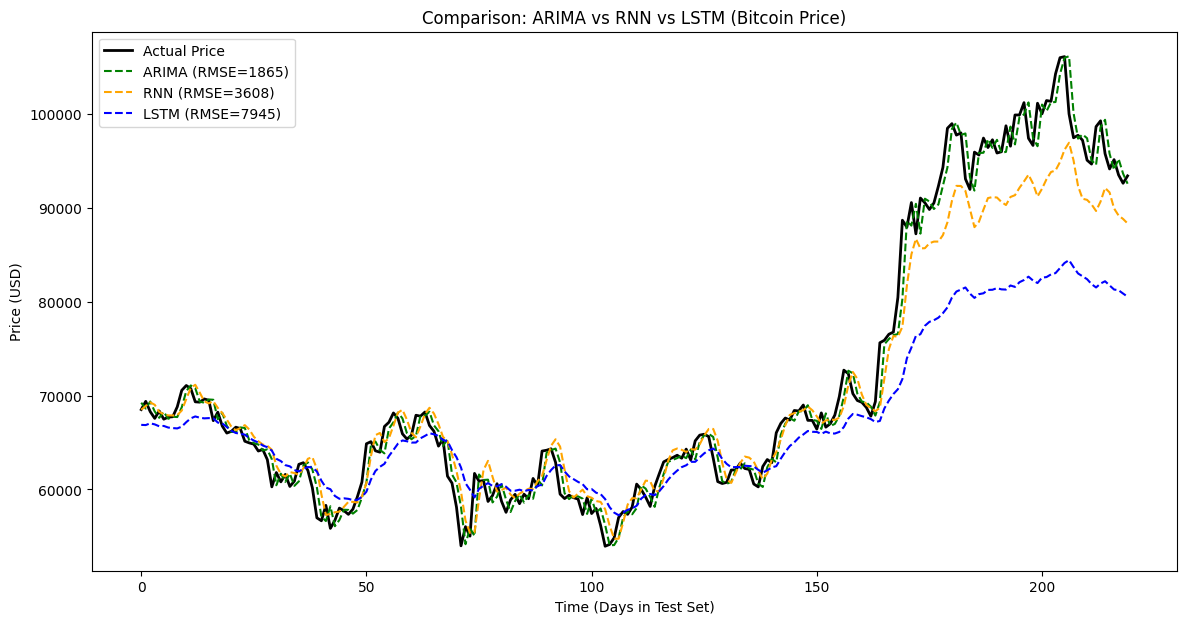

In [26]:
# 1. Get Data
train_data, test_data = get_btc_data()

# 2. Run Models
preds_arima = run_arima(train_data, test_data)
preds_rnn = run_rnn(train_data, test_data)
preds_lstm = run_lstm(train_data, test_data)

# 3. Calculate Errors (RMSE)
rmse_arima = np.sqrt(mean_squared_error(test_data, preds_arima))
rmse_rnn = np.sqrt(mean_squared_error(test_data, preds_rnn))
rmse_lstm = np.sqrt(mean_squared_error(test_data, preds_lstm))

print(f"\n--- Results (RMSE) ---")
print(f"ARIMA RMSE: {rmse_arima:.2f}")
print(f"RNN RMSE:   {rmse_rnn:.2f}")
print(f"LSTM RMSE:  {rmse_lstm:.2f}")

# 4. Plot Comparison
plt.figure(figsize=(14, 7))
plt.plot(test_data, label='Actual Price', color='black', linewidth=2)
plt.plot(preds_arima, label=f'ARIMA (RMSE={rmse_arima:.0f})', color='green', linestyle='--')
plt.plot(preds_rnn, label=f'RNN (RMSE={rmse_rnn:.0f})', color='orange', linestyle='--')
plt.plot(preds_lstm, label=f'LSTM (RMSE={rmse_lstm:.0f})', color='blue', linestyle='--')

plt.title('Comparison: ARIMA vs RNN vs LSTM (Bitcoin Price)')
plt.xlabel('Time (Days in Test Set)')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()